In [390]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from haversine import haversine, Unit

In [327]:
# Open csv downloaded using Phantombuster, the Google Maps webscraper
df = pd.read_csv('ice_cream_store_locations.csv')

In [328]:
%matplotlib inline

In [329]:
# Remove stores that are temporarily closed or are missing hours completely. These stores may no longer exist.
mask_df_hours = (df.currentStatus == 'Temporarily closed') | (df.currentStatus.isna())
df_open = df[~mask_df_hours]
list_of_open_stores = df_open[['title','latitude','longitude']]
list_of_open_stores.dropna(inplace=True)

<ipython-input-329-4c49870c1e28>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_of_open_stores.dropna(inplace=True)


In [330]:
# Open csv containing subway stations with GPS coordinates. This data set as exported as a csv from:
# https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49
list_of_subway_stations = pd.read_csv('Locations_subway_stations.csv')

In [331]:
# Sort list of subway stations alphabetically
list_of_subway_stations_sorted = list_of_subway_stations[['NAME', 'the_geom']].sort_values(by='NAME')

In [332]:
list_of_subway_stations_sorted

,NAME,the_geom
158,103rd St,POINT (-73.96837899960818 40.799446000334825)
160,103rd St,POINT (-73.96137008267617 40.796060739904526)
457,103rd St,POINT (-73.94747800152219 40.79060000008452)
188,103rd St - Corona Plaza,POINT (-73.86269999830412 40.749865000555545)
97,104th St,POINT (-73.83768300060997 40.681711001091195)
...,...,...
455,Woodlawn,POINT (-73.87875099990931 40.886037000253324)
53,Woodside - 61st St,POINT (-73.90298400173006 40.745630001138395)
408,World Trade Center,POINT (-74.00974461517701 40.71256392680817)
451,York St,POINT (-73.98688499993673 40.699742667691574)


In [333]:
# This data set needs cleaning. We need to get the coordinates into separate columns with appropriate column names.
list_of_subway_stations_sorted.columns = ['NAME', 'latitude']
list_of_subway_stations_sorted.columns

Index(['NAME', 'latitude'], dtype='object')

In [334]:
# The next few steps will remove the 'POINT' and parenthesis, and put the data into columns with appropriate labels.
# Remove 'POINT'.
list_of_subway_stations_sorted.latitude = list_of_subway_stations_sorted.latitude.str.replace('POINT', '')
list_of_subway_stations_sorted

,NAME,latitude
158,103rd St,(-73.96837899960818 40.799446000334825)
160,103rd St,(-73.96137008267617 40.796060739904526)
457,103rd St,(-73.94747800152219 40.79060000008452)
188,103rd St - Corona Plaza,(-73.86269999830412 40.749865000555545)
97,104th St,(-73.83768300060997 40.681711001091195)
...,...,...
455,Woodlawn,(-73.87875099990931 40.886037000253324)
53,Woodside - 61st St,(-73.90298400173006 40.745630001138395)
408,World Trade Center,(-74.00974461517701 40.71256392680817)
451,York St,(-73.98688499993673 40.699742667691574)


In [335]:
# Remove parenthesis.
list_of_subway_stations_sorted.latitude = list_of_subway_stations_sorted.latitude.str.replace('(', '')
list_of_subway_stations_sorted.latitude = list_of_subway_stations_sorted.latitude.str.replace(')', '')

<ipython-input-335-aea9ff6e9763>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  list_of_subway_stations_sorted.latitude = list_of_subway_stations_sorted.latitude.str.replace('(', '')
<ipython-input-335-aea9ff6e9763>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  list_of_subway_stations_sorted.latitude = list_of_subway_stations_sorted.latitude.str.replace(')', '')


In [336]:
list_of_subway_stations_sorted

,NAME,latitude
158,103rd St,-73.96837899960818 40.799446000334825
160,103rd St,-73.96137008267617 40.796060739904526
457,103rd St,-73.94747800152219 40.79060000008452
188,103rd St - Corona Plaza,-73.86269999830412 40.749865000555545
97,104th St,-73.83768300060997 40.681711001091195
...,...,...
455,Woodlawn,-73.87875099990931 40.886037000253324
53,Woodside - 61st St,-73.90298400173006 40.745630001138395
408,World Trade Center,-74.00974461517701 40.71256392680817
451,York St,-73.98688499993673 40.699742667691574


In [337]:
# We need to split the 'latitude' column (actually contains both lat and long) into a list which 
# we can then convert to a dataframe.
test = list_of_subway_stations_sorted.latitude.map(lambda x: str.split(x, ' '))

In [338]:
# test.values
test

158    [, -73.96837899960818, 40.799446000334825]
160    [, -73.96137008267617, 40.796060739904526]
457     [, -73.94747800152219, 40.79060000008452]
188    [, -73.86269999830412, 40.749865000555545]
97     [, -73.83768300060997, 40.681711001091195]
                          ...                    
455    [, -73.87875099990931, 40.886037000253324]
53     [, -73.90298400173006, 40.745630001138395]
408     [, -74.00974461517701, 40.71256392680817]
451    [, -73.98688499993673, 40.699742667691574]
29      [, -73.8470359987544, 40.836488000608156]
Name: latitude, Length: 473, dtype: object

In [339]:
# Use 'vstack' to stack the above 1D arrays on top of one another to create a 2D array. Convert that into a df.
pair_df = pd.DataFrame(np.vstack(test.values), columns=['x','longitude', 'latitude'])

In [340]:
# Reassign index to a sorted list of station names
pair_df.index = list_of_subway_stations_sorted.NAME

In [341]:
pair_df

,x,longitude,latitude
NAME,,,
103rd St,,-73.96837899960818,40.799446000334825
103rd St,,-73.96137008267617,40.796060739904526
103rd St,,-73.94747800152219,40.79060000008452
103rd St - Corona Plaza,,-73.86269999830412,40.749865000555545
104th St,,-73.83768300060997,40.681711001091195
...,...,...,...
Woodlawn,,-73.87875099990931,40.886037000253324
Woodside - 61st St,,-73.90298400173006,40.745630001138395
World Trade Center,,-74.00974461517701,40.71256392680817


In [342]:
# pair_df.reset_index()
# pair_df.drop('x', axis = 1, inplace=True)

In [343]:
# Zerega Ave 	-73.8470359987544 40.836488000608156
# pair_df.index = list_of_subway_stations_sorted.NAME

In [344]:
# pair_df.index

In [345]:
# change the name of 'pair_df' to something more understandable.
list_of_subway_stations_sorted = pair_df

In [346]:
list_of_subway_stations_sorted.sample(3, random_state = 31).sort_values(by=['NAME'])

,x,longitude,latitude
NAME,,,
104th St,,-73.83768300060997,40.681711001091195
Atlantic Av - Barclay's Center,,-73.97754993539385,40.68442016526762
Bedford Park Blvd - Lehman College,,-73.89006400069478,40.87341199980121


In [347]:
# Now that we have a list of subway stations and coordinates, we need to match that up with the MTA subway data.
# The station names from the turnstile data do not match the names from the data set pulled above. For example,
# the locations data set has '103rd st' while the turnstile data has that labeled '103 st' so we need to 
# process both data sets to create a single data set using the coordinates from the locations data set
# with station names from the turnstile data.
df_turnstile = pd.read_csv('turnstile_data.csv') 

In [348]:
# Now we have to match station names across both data sets.

# Convert all station names to lowercase.
MTA_turnstile_stations = df_turnstile.STATION.str.lower()

# Create a list of unique station names. No need for duplicates because we're trying to create a 1:1 dictionary to match 
# the names from the locations data set to the turnstile data set.
MTA_turnstile_stations = sorted(list(MTA_turnstile_stations.unique()))
MTA_location_stations = list(list_of_subway_stations_sorted.index.unique())

# Create a list of unique subway locations in lowercase.
temp = [x.lower() for x in MTA_location_stations]
MTA_location_stations = temp

In [349]:
# MTA_turnstile_stations
MTA_location_stations

['103rd st',
 '103rd st - corona plaza',
 '104th st',
 '104th-102nd sts',
 '110th st',
 '111th st',
 '116th st',
 '116th st - columbia university',
 '121st st',
 '125th st',
 '135th st',
 '137th st - city college',
 '138th st - grand concourse',
 '145th st',
 '149th st - grand concourse',
 '14th st',
 '155th st',
 '157th st',
 '15th st - prospect park',
 '161st st - yankee stadium',
 '163rd st - amsterdam av',
 '167th st',
 '168th st',
 '169th st',
 '170th st',
 '174th st',
 '174th-175th sts',
 '175th st',
 '176th st',
 '181st st',
 '182nd-183rd sts',
 '183rd st',
 '18th ave',
 '18th st',
 '190th st',
 '191st st',
 '1st ave',
 '207th st',
 '20th ave',
 '215th st',
 '219th st',
 '21st st',
 '21st st - queensbridge',
 '225th st',
 '231st st',
 '233rd st',
 '238th st',
 '23rd st',
 '25th ave',
 '25th st',
 '28th st',
 '30th ave',
 '33rd st',
 '34th st - hudson yards',
 '34th st - penn station',
 '36th ave',
 '36th st',
 '39th ave',
 '3rd ave',
 '3rd ave - 138th st',
 '3rd ave - 149th st',

In [350]:
# Now that we have two lists of unique station names, we need to match them up. For that, 
# we'll import get_close_matches from the difflib package shown in the next cell.
from difflib import get_close_matches

In [351]:
def closeMatches(patterns, word):
     return get_close_matches(word, patterns)

# Create an empty dictionary that we will fill with the results of the closeMatches function.
result = {}

# Loop through the names from the turnstile data set and compare each name with the list of names from the locations
# data set and return the closest matches.
for station in MTA_turnstile_stations:
    result[station] = closeMatches(MTA_location_stations, station)

print(result) 

# The resulting dictionary contains as its keys the list of station names from the turnstile data set. The values are
# the closest matches provided by the get_close_matches function. The name at index 0 is the closest match.

{'1 av': ['1st ave', '18th ave'], '103 st': ['103rd st', '190th st', '183rd st'], '103 st-corona': ['103rd st - corona plaza'], '104 st': ['104th st', '14th st', '190th st'], '110 st': ['110th st', '191st st', '190th st'], '111 st': ['111th st', '191st st', '181st st'], '116 st': ['116th st', '191st st', '181st st'], '116 st-columbia': ['116th st - columbia university'], '121 st': ['121st st', '21st st', '231st st'], '125 st': ['125th st', '25th st', '225th st'], '135 st': ['135th st', '215th st', '183rd st'], '137 st city col': ['137th st - city college'], '138/grand conc': ['138th st - grand concourse'], '14 st': ['14th st', '174th st', '145th st'], '14 st-union sq': ['union st'], '145 st': ['145th st', '45th st', '14th st'], '149/grand conc': ['149th st - grand concourse'], '14th street': ['14th st', '174th st', '145th st'], '15 st-prospect': ['15th st - prospect park', 'prospect ave'], '155 st': ['155th st', '55th st', '215th st'], '157 st': ['157th st', '57th st', '215th st'], '16

In [352]:
# Convert this dictionary to a df for easier visualization.
df_stations = pd.DataFrame.from_dict(result, orient='index')

In [353]:
df_stations

,0,1,2
1 av,1st ave,18th ave,None
103 st,103rd st,190th st,183rd st
103 st-corona,103rd st - corona plaza,None,None
104 st,104th st,14th st,190th st
110 st,110th st,191st st,190th st
...,...,...,...
woodlawn,woodlawn,None,None
world trade ctr,world trade center,None,None
wtc-cortlandt,cortlandt st,None,None
york st,york st,court st,clark st


In [354]:
# At this point, we need to manually go through the list and check to see if each match is correct. Export results 
# to a csv for manual inspection. One station found no match because '33rd st' was written 'thirty-third street'.
# Some stations in the turnstile data set simply had no equivalent in the locations data set so these were eliminated.
# We can't use the turnstile data from stations we cannot place on a map. For future work, we can locate these stations
# and update the data accordingly.
df_stations.to_csv('station_name_match.csv')

In [355]:
df_station_match = pd.read_csv('station_name_match_cleaned.csv')

In [356]:
df_station_match.head()

,Unnamed: 0,0,1,2,Unnamed: 4
0,1 av,1st ave,18th ave,NaN,NaN
1,103 st,103rd st,190th st,183rd st,NaN
2,103 st-corona,103rd st - corona plaza,NaN,NaN,NaN
3,104 st,104th st,14th st,190th st,NaN
4,110 st,110th st,191st st,190th st,NaN


In [357]:
# This df looks terrible so we will clean it up. Give the useful columns names and drop the non-useful columns.
df_station_match.columns = ['Name from turnstile data', 'Name from MTA station list', 1,2,3]

In [358]:
df_station_match.set_index(['Name from turnstile data'], inplace = True)

In [359]:
df_station_match.drop([1,2,3], axis = 1, inplace=True)

In [360]:
df_station_match
# Much better.

,Name from MTA station list
Name from turnstile data,
1 av,1st ave
103 st,103rd st
103 st-corona,103rd st - corona plaza
104 st,104th st
110 st,110th st
...,...
woodlawn,woodlawn
world trade ctr,world trade center
wtc-cortlandt,cortlandt st


In [361]:
print(df_station_match.iloc[34:47,:])

# Some stations like 2 av had no coordinates so this station will be dropped.
df_station_match.dropna(subset=['Name from MTA station list'], inplace=True)

                         Name from MTA station list
Name from turnstile data                           
182-183 sts                         182nd-183rd sts
183 st                                     183rd st
190 st                                     190th st
191 st                                     191st st
2 av                                            NaN
20 av                                      20th ave
207 st                                     207th st
21 st                                       21st st
21 st-qnsbridge              21st st - queensbridge
215 st                                     215th st
219 st                                     219th st
225 st                                     225th st
23 st                                       23rd st


In [362]:
list_of_subway_stations_sorted.index = list_of_subway_stations_sorted.index.str.lower()

In [363]:
# Remove this extra 'x' column
list_of_subway_stations_sorted.drop('x', axis=1, inplace=True)

In [364]:
# Make sure names of station lists are correctly labeled.
test_df_station_match = df_station_match
test_df_station_match.reset_index(inplace=True)
test_df_station_match.set_index('Name from MTA station list', inplace=True)
test_df_station_match

,Name from turnstile data
Name from MTA station list,
1st ave,1 av
103rd st,103 st
103rd st - corona plaza,103 st-corona
104th st,104 st
110th st,110 st
...,...
woodlawn,woodlawn
world trade center,world trade ctr
cortlandt st,wtc-cortlandt


In [365]:
# Now merge the two dataframes. The df with the location data will be on the left and the name from the turnstile
# data will be on the right. Merge on the axis of each df.
merged_station_locations = (pd.merge(list_of_subway_stations_sorted, test_df_station_match,  
          left_index=True, right_index=True))

# This next line deletes extra columns that get created each time you run pd.merge. 
# This only becomes a problem if you run this cell multiple times to try and get it to work.
merged_station_locations.drop(merged_station_locations.iloc[:, 4:], axis = 1, inplace=True)

merged_station_locations.index.name = 'Name from MTA station list'
merged_station_locations
# Looks pretty good. This is what we want.

,longitude,latitude,Name from turnstile data
Name from MTA station list,,,
103rd st,-73.96837899960818,40.799446000334825,103 st
103rd st,-73.96137008267617,40.796060739904526,103 st
103rd st,-73.94747800152219,40.79060000008452,103 st
103rd st - corona plaza,-73.86269999830412,40.749865000555545,103 st-corona
104th st,-73.83768300060997,40.681711001091195,104 st
...,...,...,...
woodhaven blvd,-73.85205199740794,40.69370399880105,woodhaven blvd
woodlawn,-73.87875099990931,40.886037000253324,woodlawn
world trade center,-74.00974461517701,40.71256392680817,world trade ctr


In [366]:
# Now, in order to process the coordinates, we need to convert them to floats.
merged_station_locations[['longitude', 'latitude']] = merged_station_locations[['longitude', 'latitude']].astype('float')

In [367]:
merged_station_locations.dtypes
# It worked.

longitude                   float64
latitude                    float64
Name from turnstile data     object
dtype: object

Now we need to put the stations on a map. Eventually, we will identify stations with a high degree of foot traffic 
and see if there are any ice cream stores nearby. A computationally inexpensive way to do this is to map each
ice cream store location onto a 'sector map'. The sector map will be divided into square sectors with a length
equal to one (1) city block. We will bound the 'sector map' by the western-, northern-, eastern-, and southern-most
stations. When we place a subway station on the sector map, we will also mark off the sectors adjacent to the one 
containing the station.

In [368]:
# Find boundaries of sector map.
# long_max = merged_station_locations.longitude.max()
# long_min = merged_station_locations.longitude.min()
# lat_max = merged_station_locations.latitude.max()
# lat_min = merged_station_locations.latitude.min()

long_max = max(merged_station_locations.longitude.max(), list_of_open_stores.longitude.max())
long_min = min(merged_station_locations.longitude.min(), list_of_open_stores.longitude.min())
lat_max = max(merged_station_locations.latitude.max(), list_of_open_stores.latitude.max())
lat_min = min(merged_station_locations.latitude.min(), list_of_open_stores.latitude.min())

In [369]:
# Make the limits into a df so it's more readable. Calculate step size using map coordinates equal to the lenth of
# one city block on the Upperwest Side of Manhattan.
sector_limits = pd.DataFrame({
    'longitude' : [long_min, long_max, long_max-long_min, 0.000483],
    'latitude' : [lat_min, lat_max, lat_max-lat_min, 0.000648]
})

In [370]:
sector_limits.index = ['min', 'max', 'range', 'step size']
sector_limits

,longitude,latitude
min,-74.045438,40.576034
max,-73.755405,40.903125
range,0.290033,0.327091
step size,0.000483,0.000648


One city block equals: longitude 0.000483, latitude 0.000648 <br>
Set origin at max latitude, min longitude. <br>
Latitude goes up as you go north and longitude goes up as you go east. <br>
The grid will have 0.275471/0.000483 = 601 columns and 504 rows. <br>
Pad the grid by one row and column because the dimensions are set by the list scraped from Google. Without padding, the code with generate an index error.

In [371]:
sector_map = pd.DataFrame(columns = range(-1, 603), index = range(-1, 506))
# Set all elements to 0 so we can increment them when we start placing stations and ice cream stores
sector_map.fillna(0, inplace=True)
sector_map

,-1,0,1,2,3,4,5,6,7,8,...,593,594,595,596,597,598,599,600,601,602
-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
504,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each store will be located inside a sector. As an example to find the sector coordinates, let's use an example coordinate of 40.739119, -73.993974. Find the sector by subtracting the lat_min, long_min and dividing by the step size (for long: 0.000483, and for lat: 0.000648). This puts the location in Sector (76, 337) (long, lat). Use floor division to generate an integer.

In [372]:
# Add column containing sector info to merged station list.
merged_station_locations['sector_long'] = (
    (merged_station_locations.longitude - sector_limits.loc['min', 'longitude'])//sector_limits.loc['step size', 'longitude']
)                                     
merged_station_locations['sector_lat'] = (
    (merged_station_locations.latitude - sector_limits.loc['min', 'latitude'])//sector_limits.loc['step size', 'latitude']
)  

In [373]:
merged_station_locations

,longitude,latitude,Name from turnstile data,sector_long,sector_lat
Name from MTA station list,,,,,
103rd st,-73.968379,40.799446,103 st,159.0,344.0
103rd st,-73.961370,40.796061,103 st,174.0,339.0
103rd st,-73.947478,40.790600,103 st,202.0,331.0
103rd st - corona plaza,-73.862700,40.749865,103 st-corona,378.0,268.0
104th st,-73.837683,40.681711,104 st,430.0,163.0
...,...,...,...,...,...
woodhaven blvd,-73.852052,40.693704,woodhaven blvd,400.0,181.0
woodlawn,-73.878751,40.886037,woodlawn,345.0,478.0
world trade center,-74.009745,40.712564,world trade ctr,73.0,210.0


In [374]:
# Reorganize columns to make them more readable.
merged_station_locations = merged_station_locations[['Name from turnstile data', 'longitude', 'latitude', 'sector_long', 'sector_lat']]

In [375]:
# Convert sector data to ints.
merged_station_locations[['sector_long', 'sector_lat']] = merged_station_locations[['sector_long', 'sector_lat']].astype('int')

The next step is to populate the empty sector map with subway stations. Each location will be padded by one (1) city-block. When we generate the list of subway stations with high foot traffic and attempt to place the stations on the sector map, if the element we are trying to fill is NOT NaN, that means there is an ice cream store already within one block of that location.

In [376]:
# Add column containing sector info to ice cream store list.
list_of_open_stores['sector_long'] = (
    (list_of_open_stores.longitude - sector_limits.loc['min', 'longitude'])//sector_limits.loc['step size', 'longitude']
)                                     
list_of_open_stores['sector_lat'] = (
    (list_of_open_stores.latitude - sector_limits.loc['min', 'latitude'])//sector_limits.loc['step size', 'latitude']
)  

<ipython-input-376-de52b459b4c0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_of_open_stores['sector_long'] = (
<ipython-input-376-de52b459b4c0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_of_open_stores['sector_lat'] = (


In [377]:
# Convert sector data to ints.
list_of_open_stores[['sector_long', 'sector_lat']] = list_of_open_stores[['sector_long', 'sector_lat']].astype('int')

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [378]:
empty_sector_map = pd.DataFrame(columns = range(-1, 603), index = range(-1, 506))
# Set all elements to 0 so we can increment them when we start placing stations and ice cream stores
empty_sector_map.fillna(0, inplace=True)


# Create two lists of stations: one for station longitudes, one for station latitudes.
x_stations = list(merged_station_locations.sector_long)
y_stations = list(merged_station_locations.sector_lat)

# Pad the list so that each x,y location is surrounded by 8 other locations in all cardinal directions.
x_stations_padded = []
y_stations_padded = []

# for x in x_stations:
#     x_stations_padded += [x - 1, x - 1, x - 1, x, x, x, x + 1, x + 1, x + 1]
# for y in y_stations:
#     y_stations_padded += [y - 1, y, y + 1, y - 1, y, y + 1, y - 1, y, y + 1]

for x in x_stations:
    x_stations_padded += [x]
for y in y_stations:
    y_stations_padded += [y]
    
# x_stations_padded = [2,5]
# y_stations_padded = [1,0]    

stations_padded = list(zip(x_stations_padded, y_stations_padded))
# For each location, increment the value in the sector map by '1'.
# stations_padded = list(map(list, zip(x_stations_padded, y_stations_padded)))#(x_stations_padded, y_stations_padded)
# print(stations_padded)


for x, y in stations_padded:
    empty_sector_map.loc[y,x] += 1



# empty_sector_map.loc[list(stations_padded)] += 1

# empty_sector_map.loc[y_stations_padded, x_stations_padded] += 1
station_sector_map = empty_sector_map

# Reset sector map so as to populate with just ice cream stores.
empty_sector_map = pd.DataFrame(columns = range(-1, 603), index = range(-1, 506))
empty_sector_map.fillna(0, inplace=True)

# Create two lists of stations: one for station longitudes, one for station latitudes.
x_stores = list(list_of_open_stores.sector_long)
y_stores = list(list_of_open_stores.sector_lat)

# Pad the list so that each x,y location is surrounded by 8 other locations in all cardinal directions.
x_stores_padded = []
y_stores_padded = []

for x in x_stores:
    x_stores_padded += [x - 1, x - 1, x - 1, x, x, x, x + 1, x + 1, x + 1]
for y in y_stores:
    y_stores_padded += [y - 1, y, y + 1, y - 1, y, y + 1, y - 1, y, y + 1]

# For each location, change the value in the sector map to '1'. It could be anything except NaN.

stores_padded = list(zip(x_stores_padded, y_stores_padded))

for x, y in stores_padded:
    empty_sector_map.loc[y, x] += 1
store_sector_map = empty_sector_map

# Reset sector map. 
empty_sector_map = pd.DataFrame(columns = range(-1, 603), index = range(-1, 506))
empty_sector_map.fillna(0, inplace=True)

# Add both the ice cream stores and stations.

for x, y in stores_padded + stations_padded:
    empty_sector_map.loc[y, x] += 1

    
# empty_sector_map.loc[y_stores_padded, x_stores_padded] += 1
# empty_sector_map.loc[y_stations_padded, x_stations_padded] += 1

station_store_sector_map = empty_sector_map


<AxesSubplot:>

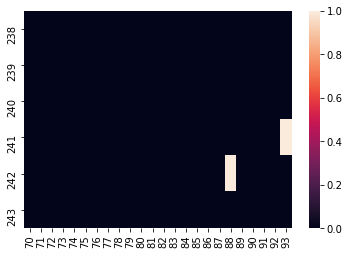

In [379]:
sns.heatmap(station_sector_map.iloc[239:245,71:95])

Populate sector_map with ice cream store locations. Then run a loop. For each station with high traffic, find the value of the element on the map. A value of 1 indicates there is one ice cream store within one block. A value of 2 indicates there are 2 ice cream stores within 1 block. A value of 0 indicates there are NO ice cream stores within one block. Ideally, a high-traffic station will have a 0 in the sector map corresponding to its location.

for each station in list:
    station['number of ice cream stores'] = sector_map value
   
Sort the resulting list by order of ice cream stores.

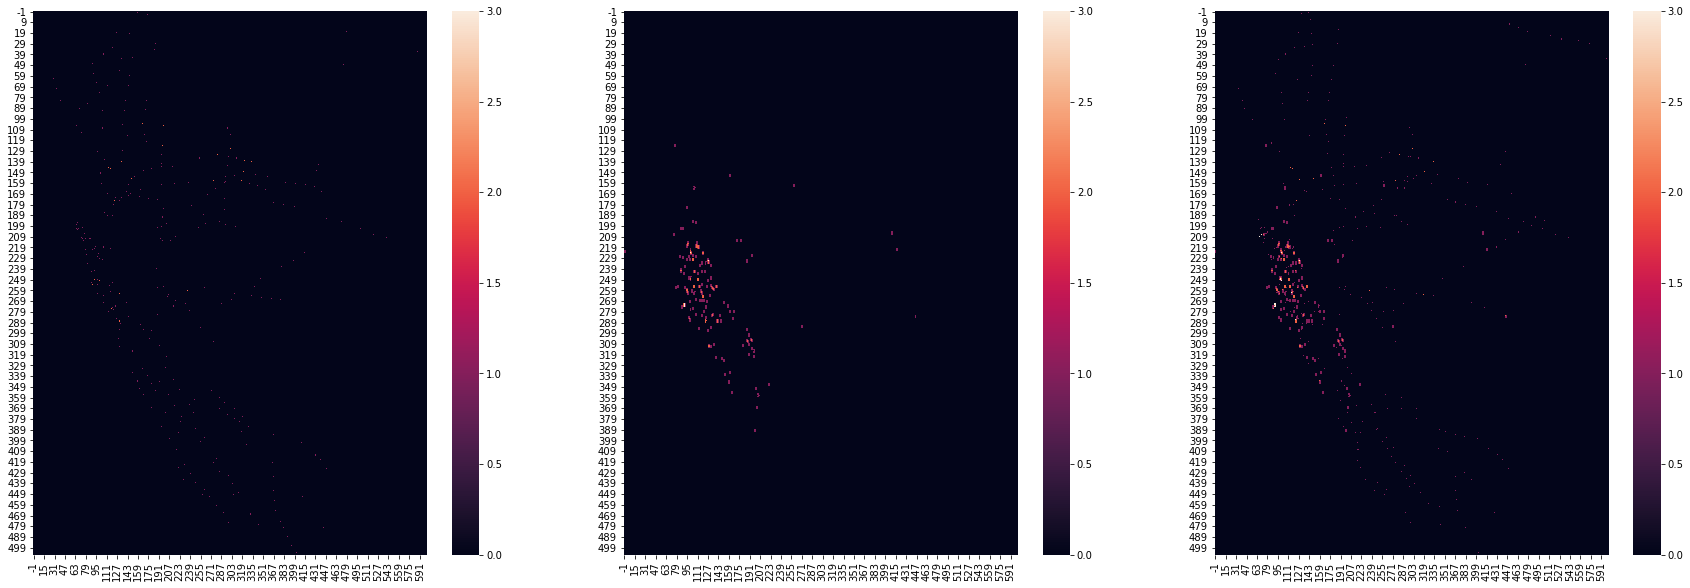

In [380]:
# multiple heatmaps using subplots
 
plt.figure(figsize=(30,10))
 
plt.subplot(1,3,1) # first heatmap
sns.heatmap(station_sector_map)

plt.subplot(1,3,2) # second heatmap
sns.heatmap(store_sector_map)

plt.subplot(1,3,3) # third heatmap
sns.heatmap(station_store_sector_map)

plt.show()

# station_sector_map
# store_sector_map
# station_store_sector_map


<AxesSubplot:>

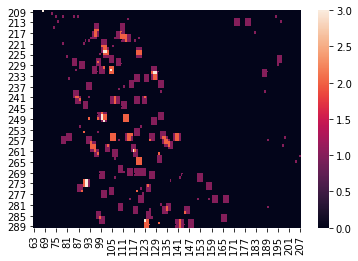

In [381]:
sns.heatmap(station_store_sector_map.loc[209:289, 63:207])

Black are areas that have neither subway nor ice cream store. Red has either subway or store, not both. White has both subway and ice cream store.

Zoom in on the sector map to include just manhattan.

<AxesSubplot:>

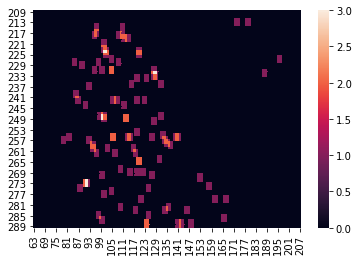

In [382]:
sns.heatmap(store_sector_map.loc[209:289, 63:207])

In [383]:
# sector_map.iloc[0:50,95:125]
# sector_map.value_counts()
unique_vals = station_sector_map.nunique()
unique_vals[unique_vals > 2]

71     3
90     3
93     3
101    3
115    3
118    3
131    3
134    3
167    3
197    3
199    3
276    3
302    3
318    3
334    3
dtype: int64